# Region Encoding Extraction

The RPN module of mlmodule allows users to extract regions from images using RPNs, and to create encodings for these regions using a DenseNet pretrained on ImageNet.

## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%cd ..

### Imports

In [3]:
import pickle
import os
import time

import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import Compose

from mmdet.apis import init_detector, inference_detector

from mlmodule.contrib.rpn import RegionFeatures, RPN, CosineSimilarityRegionSelector, DenseNet161ImageNetEncoder
from mlmodule.torch.data.base import IndexedDataset
from mlmodule.torch.data.images import convert_to_rgb, get_pil_image_from_file
from mlmodule.utils import list_files_in_dir

### Loading Images

In [4]:
num_images = 10

img_file_names_path = '../imagenet_densenet201_softmax.pkl'

file_names = []
for i, k in enumerate(pickle.load(open(img_file_names_path, 'rb')).keys()):
    file_names.append(k)

# List of paths of images to test the RPN on
file_names = [f for f in file_names if os.path.isfile(f)]
file_names = file_names[:num_images]

In [5]:
def get_images():
    transforms = Compose([
        get_pil_image_from_file,
        convert_to_rgb
    ])
    return file_names, [transforms(f) for f in file_names]

In [6]:
indices, images = get_images()

### Region Extraction Parameters

In [7]:
MIN_SCORE = 0.5
NUM_REGIONS = 30

### Helpers

In [8]:
def add_boxes(image, boxes, c=(255, 0, 0)):
    img = image.copy()
    for bbox in boxes:
        x0, y0 = int(bbox[0]), int(bbox[1])
        x1, y1 = int(bbox[2]), int(bbox[3])
        cv2.rectangle(img, (x0, y0), (x1, y1), c, 2)
    return img


def plot_image_data(img_index):
    img_path, regions = regions_with_features[img_index]
    img = np.array(convert_to_rgb(get_pil_image_from_file(img_path)))
    
    # mlmodule boxes
    boxes_taken = []
    boxes_not_taken = []
    for r in regions:
        b0, b1 = r.bounding_box
        if r.features is not None:
            boxes_taken.append([b0.x, b0.y, b1.x, b1.y])
        else:
            boxes_not_taken.append([b0.x, b0.y, b1.x, b1.y])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    ax1.set_title(f'mlmodule: Regions Kept ({len(boxes_taken)})')
    ax1.imshow(add_boxes(img, boxes_taken, c=(255, 0, 0)))
    ax2.set_title(f'mlmodule: Regions Discarded ({len(boxes_not_taken)})')
    ax2.imshow(add_boxes(img, boxes_not_taken, c=(255, 0, 0)))
    plt.tight_layout()
    plt.show()

## Using mlmodule

### Creating the Dataset

In [9]:
dataset = IndexedDataset[str, np.ndarray, np.ndarray](indices, images)

### Loading the Models

To load a model other than the default:

```python
def rpn_from_config_and_checkpoint():
    base_path = 'src/mlmodule/contrib/rpn'
    model = 'ga_rpn_x101_32x4d_fpn_1x_coco
    # Path to the config
    config = f'{base_path}/configs/guided_anchoring/{model}.py'
    # Path the the checkpoint
    checkpoint = f'{base_path}/checkpoints/{model}_20200220-c28d1b18.pth'

    # Initialize RPN
    model = RPN(config, device='cuda:0')
    # Load checkpoint
    with open(checkpoint, 'rb') as f:
        model.load(f)
    return model
```

In [10]:
def rpn():
    # Initialize RPN
    model = RPN(device='cuda:0')
    # Load checkpoint
    model.load()
    return model


def region_encoder():
    densenet = DenseNet161ImageNetEncoder(device='cuda:0')
    densenet.load()
    return densenet


def region_selector():
    return CosineSimilarityRegionSelector(device='cuda:0')

In [11]:
rpn = rpn()
region_encoder = region_encoder()
region_selector = region_selector()

In [12]:
region_features = RegionFeatures(rpn, region_encoder, region_selector)

### Computing Image Regions and Their Encodings

In [13]:
t0 = time.time()
regions_with_features = region_features.bulk_inference(
    dataset,
    regions_per_image=NUM_REGIONS,
    min_region_score=MIN_SCORE
)
t1 = time.time()

print(f'Images in dataset: {len(dataset)}')
print(f'Runtime:           {t1 - t0:.1f} seconds')
print(f'Per image:         {len(dataset)/(t1 - t0):.1f} images/second')

Images in dataset: 10
Runtime:           17.4 seconds
Per image:         0.6 images/second


## Analysing Results

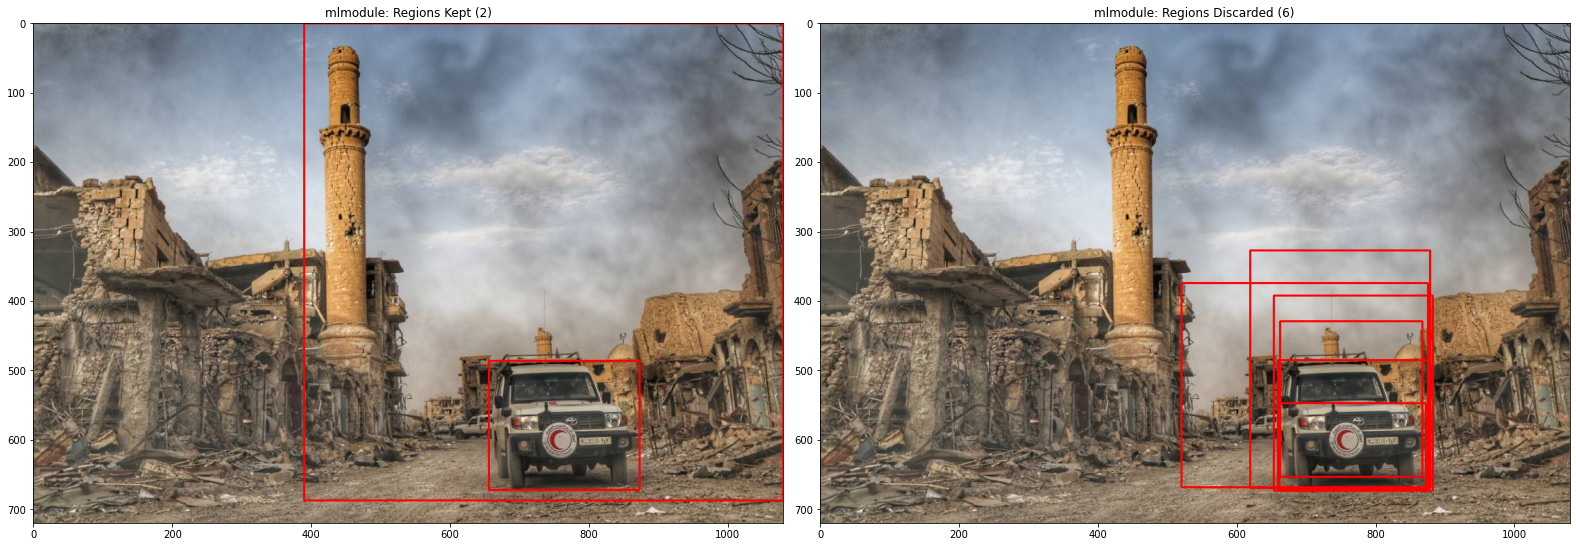

In [14]:
plot_image_data(0)

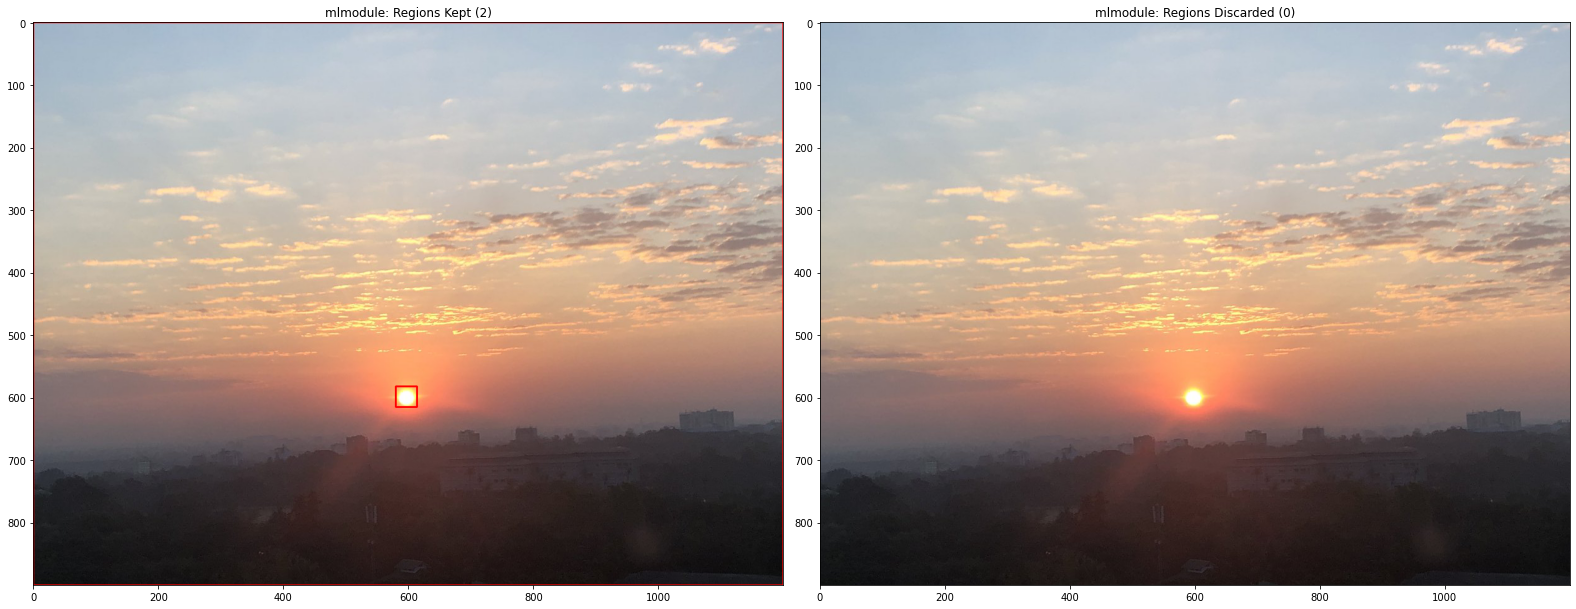

In [15]:
plot_image_data(1)

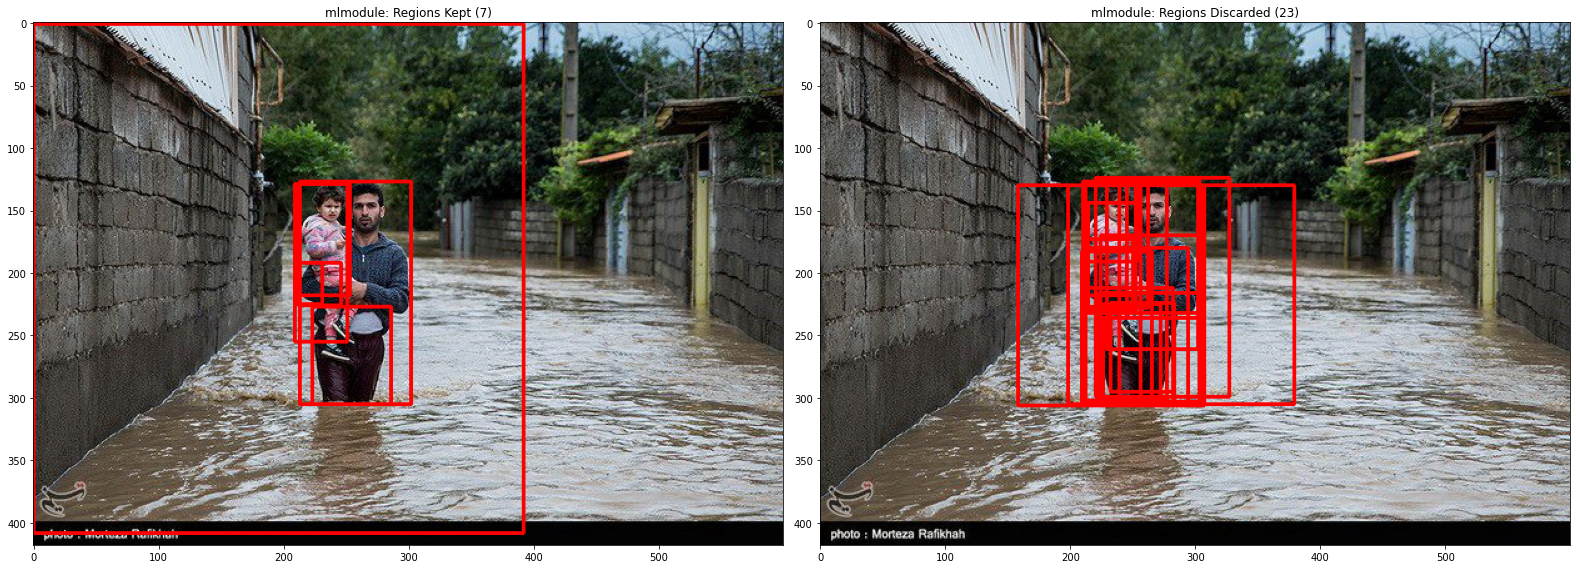

In [16]:
plot_image_data(2)

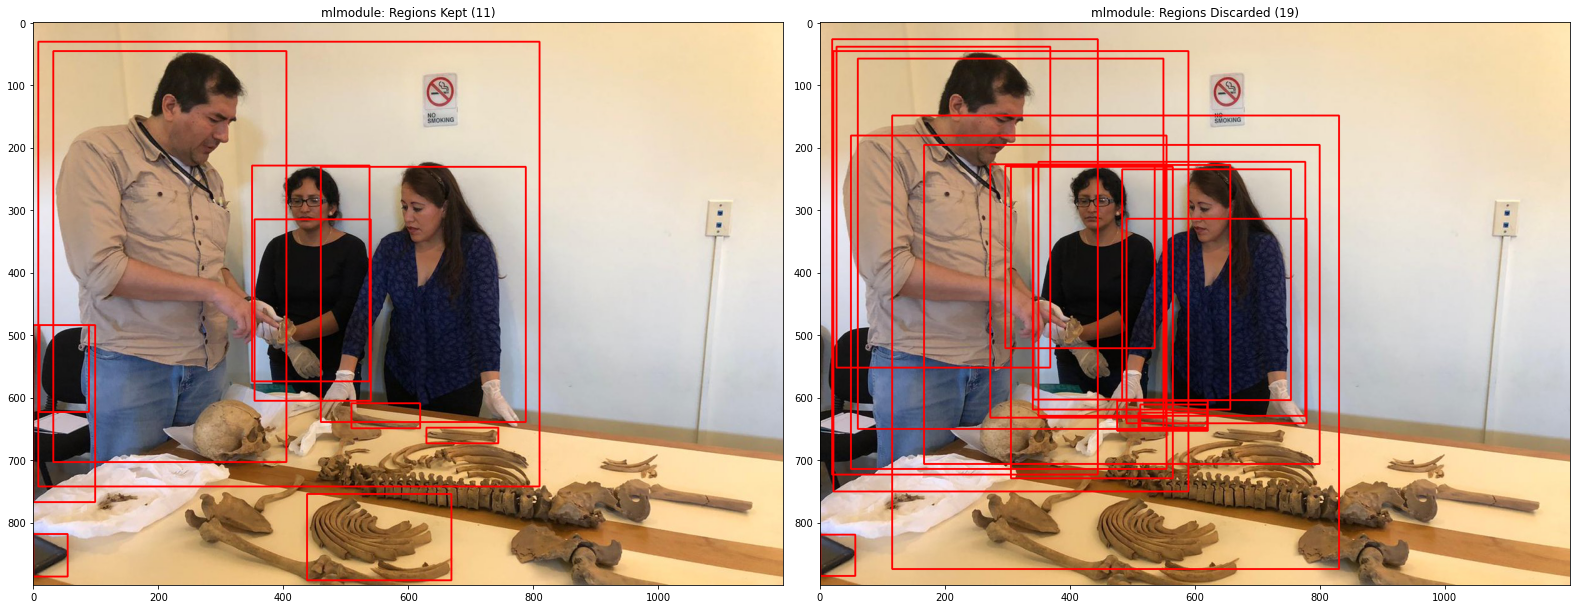

In [17]:
plot_image_data(3)